In [2]:
import os
import datetime
import random # random.seed(42)
import warnings
import numpy as np # np.random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize,LinearSegmentedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.exceptions
from sklearn.utils import class_weight
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from tensorflow.config.experimental import enable_op_determinism # enable_op_determinism()
from tensorflow.random import set_seed # set_seed(42)
from tensorflow.python.client import device_lib

from keras import backend as K
from keras.utils import load_img, img_to_array, set_random_seed # set_random_seed(42)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.layers import Input, GlobalAveragePooling2D, ZeroPadding2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import applications
finish_sound = "afplay /Users/mehmet/Documents/vs-code/winsquare.mp3"
# !conda install -y -n ml ipykernel=6.23.2 numpy==1.24.0 matplotlib=3.7.1 pandas=2.0.2 seaborn=0.12.1 scikit-learn=1.3.2 tensorflow=2.11.1
# !jupyter nbconvert --to html skin-cancer-cnn.ipynb
[x.name for x in device_lib.list_local_devices()]

['/device:CPU:0']

In [3]:
# Train and test data paths
train_path = "dataverse_files/HAM10000_images_pca"
test_path = "dataverse_files/ISIC2018_Task3_Test_Images"

# Read the data
df = pd.read_csv('dataverse_files/HAM10000_metadata.csv')
df_test = pd.read_csv('dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv')

# Delete df and vasc classes
df = df[df['dx'] != 'vasc']
df = df[df['dx'] != 'df']
df_test = df_test[df_test['dx'] != 'vasc']
df_test = df_test[df_test['dx'] != 'df']

labels = df['dx'].sort_values().unique()

# Add .jpg to image_id column
df['image_id'] = df['image_id'].astype(str) + '.jpg'
df_test['image_id'] = df_test['image_id'].astype(str) + '.jpg'

# Drop unused columns
# df=df.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
# df_test=df_test.drop(['lesion_id',  'dx_type', 'age', 'sex', 'localization', 'dataset'], axis=1)
df=df.drop(['lesion_id', 'dataset'], axis=1)
df_test=df_test.drop(['lesion_id', 'dataset'], axis=1)

# 'ISIC_0035068.jpg' is missing in the test set file, lets remove it from test set dataframe
df_test = df_test[df_test['image_id'] != 'ISIC_0035068.jpg']

print(labels,'\n')

df.sort_values(by=['image_id'], inplace=True)
df.reset_index(inplace=True, drop=True)
df_test.sort_values(by=['image_id'], inplace=True)
df_test.reset_index(inplace=True, drop=True)

train_df, val_df=train_test_split(df, train_size=0.9, shuffle=True, random_state=123, stratify=df['dx'])
train_df.reset_index(inplace=True, drop=True)
val_df.reset_index(inplace=True, drop=True)
test_df = df_test.copy().sample(frac=1, random_state=123).reset_index(drop=True) # shuffle test set

['akiec' 'bcc' 'bkl' 'mel' 'nv'] 



In [4]:
#To use augmented data
x = '_3'
train_path = 'dataverse_files/HAM10000_images_pca_augmented'+x
train_df = pd.read_csv('dataverse_files/HAM10000_metadata_augmented'+x+'_train.csv')
val_df = pd.read_csv('dataverse_files/HAM10000_metadata_augmented'+x+'_val.csv')

In [5]:
for label in labels:
    list1 = len(train_df[train_df['dx'] == label]), len(val_df[val_df['dx'] == label]), len(test_df[test_df['dx'] == label])
    space = ' '
    print(label,(5-len(label))*space ,list1)
    
train_df.shape, val_df.shape, test_df.shape

akiec  (1000, 70, 43)
bcc    (1000, 70, 93)
bkl    (1011, 80, 217)
mel    (1067, 70, 171)
nv     (1100, 80, 908)


((5178, 8), (370, 8), (1432, 6))

In [6]:
rescale=1./255
color_mode = 'rgb'
target_size = (32, 32)
batch_size  = 64
# 600 x 450
train_data_np = np.array([img_to_array(load_img(train_path+'/'+img, target_size=target_size)) for img in train_df['image_id'].values.tolist()])

datagen = ImageDataGenerator(rescale=rescale,
                            featurewise_center=True,
                            featurewise_std_normalization=True)
datagen.fit(train_data_np)
train_set = datagen.flow_from_dataframe(train_df,
                                        directory=train_path,
                                        x_col="image_id",
                                        y_col="dx",
                                        color_mode=color_mode,
                                        target_size=target_size,
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False
                                        )

val_set = datagen.flow_from_dataframe(val_df,
                                      directory=train_path,
                                      x_col="image_id",
                                      y_col="dx",
                                      color_mode=color_mode,
                                      target_size=target_size,
                                      batch_size=batch_size,
                                      class_mode='categorical',
                                      shuffle=False
                                      )
test_set = datagen.flow_from_dataframe(test_df,
                                       directory=test_path,
                                       x_col="image_id",
                                       y_col="dx",
                                       color_mode=color_mode,
                                       target_size=target_size,
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                       shuffle=False
                                       )

Found 5178 validated image filenames belonging to 5 classes.
Found 370 validated image filenames belonging to 5 classes.
Found 1432 validated image filenames belonging to 5 classes.


In [7]:
def loss_plot(model, history, now, save=True):
    # convert the history.history dict to a pandas DataFrame:
    if type(history) is not pd.DataFrame:
        history = pd.DataFrame(history)
    if save == True:
        hist_csv_file = f'model-comparison/{now}/history.csv'
        with open(hist_csv_file, mode='w') as f:
            history.to_csv(f) 
    epochs = range(1, history.shape[0]+1)
    plt.figure(figsize=(5, 2))
    plt.plot(epochs, history['accuracy'], label='Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    max_val_acc_epoch = np.argmax(history['val_accuracy']) + 1
    max_val_acc = history['val_accuracy'][max_val_acc_epoch-1]
    label='Best Epoch = '+str(max_val_acc_epoch)+'\nVal. Acc. = '+str((max_val_acc*100).round(2))+ '%'
    plt.plot(max_val_acc_epoch, max_val_acc, 'ro', label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xlim([0, history.shape[0]+0.1])
    plt.ylim([0.5, 1])
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='upper left')
    if save == True:
        plt.savefig(f'model-comparison/{now}/val-acc.png')
        np.savetxt('model-comparison/{}/{}.txt'.format(now,str((max_val_acc*100).round(2))), [max_val_acc], fmt='%f')
        stats = str(now) + ' ' + str((max_val_acc*100).round(2)) + '\n'
        with open('model-comparison/best-models.txt', 'a') as f:
            f.write(stats)
    plt.show()

In [8]:
def EvaluateModel(model, test_set, str1, now, save = True, model_type='CNN'):
    
    # if file now does not exist, create it
    if not os.path.exists('model-comparison/'+now):
        os.mkdir('model-comparison/'+now)
    if model_type == 'CNN':
        print('\n PREDICTING LABELS OF TEST IMAGES')
        result = model.predict(test_set)
        y_pred = np.argmax(result, axis=1)
    else:
        y_pred = model
    if save==True:
        #save y_pred to csv file
        if not os.path.exists('model-comparison/'+now+'/'+str1):
            os.mkdir('model-comparison/'+now+'/'+str1)
        np.savetxt('model-comparison/{}/{}/pred.csv'.format(now,str1), y_pred, delimiter=',', fmt='%d')
    
    y_true = test_set.classes # List containing true labels for each image.

    # Understanding classification power of model on each class    
    report = classification_report(y_true, y_pred, target_names=test_set.class_indices.keys())
    report_d = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, target_names=test_set.class_indices.keys())).transpose()
    report_d['support']['accuracy'] = report_d['support']['macro avg']

    annot = report_d.copy()
    annot.iloc[:, 0:3] = (annot.iloc[:, 0:3]*100).applymap('{:.2f}'.format) + ' %'
    annot.iloc[7, 1] = ''
    annot.iloc[7, 0] = ''
    annot['support'] = annot['support'].astype(int)

    # how to save report as image
    norm = Normalize(-1,1)
    cmap = LinearSegmentedColormap.from_list("", [[norm(-1.0), "white"],[norm( 1.0), "white"]])
    plot = sns.heatmap(report_d, annot=annot, cmap=cmap, cbar=False, fmt='')
    fig = plot.get_figure()
    if save==True:
        fig.savefig('model-comparison/{}/{}/report.png'.format(now,str1))
    
    f1_score = ((report_d['f1-score']['weighted avg']*100000//10)/100)
    accuracy = ((report_d['f1-score']['accuracy']*100000//10)/100)
    print('\nAccuracy of model prediction is: {:.2f} %'.format(accuracy))
    print('\nF1-score of model prediction is: {:.2f} %'.format(f1_score))

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=test_set.class_indices.keys()
                              )
    disp.plot(cmap='Reds')
    disp.ax_.set_title('Confusion Matrix')
    plt.show()
    if save==True:
        disp.figure_.savefig('model-comparison/{}/{}/cm.png'.format(now,str1))

In [9]:
def train_new_model(model):
    # Extra
    #class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train_set.classes), y=train_set.classes)
    #class_weights_dict=dict(zip(np.unique(train_set.classes),class_weights))
    #keras.utils.set_random_seed(42)     
    # inside model.fit: class_weight=class_weights_dict,

    # Train new model and evaluate
    now = datetime.datetime.now().strftime("%d-%m-%H-%M")
    os.mkdir('model-comparison/'+now)
    def myprint(s):
        with open(f'model-comparison/{now}/modelsummary.txt','a') as f:
            print(s, file=f)
    model.summary(print_fn=myprint)
    with open('model-comparison/last.txt', 'w') as f:
        f.write(str(now))
    return now

In [10]:
# Extract features from CNN layers

name = '18-12-03-57' # VGG-19
#name = '18-12-03-36' # CNN
model = load_model(f"model-comparison/{name}/model.h5")

from tensorflow.keras.models import Model

# Create a new model that outputs the activations of a specific layer
#layer_name = 'dense_1'  # For CNN
layer_name = 'dense_2'  # For VGG-19

feature_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Use the feature model to extract features from your data
features_train = feature_model.predict(train_set)
features_val = feature_model.predict(val_set)
features_test = feature_model.predict(test_set)
features_train.shape, features_val.shape, features_test.shape

2023-12-18 06:08:36.990794: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


23/23 [==============================] - 6s 271ms/step


((5178, 32), (370, 32), (1432, 32))

In [11]:
train = pd.concat([train_df, pd.DataFrame(features_train)], axis=1)
train.drop(['image_id'], axis=1, inplace=True)
val = pd.concat([val_df, pd.DataFrame(features_val)], axis=1)
val.drop(['image_id'], axis=1, inplace=True)
test = pd.concat([test_df, pd.DataFrame(features_test)], axis=1)
test.drop(['image_id'], axis=1, inplace=True)
# Drop Lesion ID and dataset columns
train.drop(['lesion_id'], axis=1, inplace=True)
train.drop(['dataset'], axis=1, inplace=True)
val.drop(['lesion_id'], axis=1, inplace=True)
val.drop(['dataset'], axis=1, inplace=True)
#test.drop(['lesion_id'], axis=1, inplace=True)

#Convert numeric dx_type
train['dx_type'] = train['dx_type'].map({'histo':0, 'consensus':1, 'confocal':2, 'follow_up':3, 'consensus':4})
val['dx_type'] = val['dx_type'].map({'histo':0, 'consensus':1, 'confocal':2, 'follow_up':3, 'consensus':4})
test['dx_type'] = test['dx_type'].map({'histo':0, 'consensus':1, 'confocal':2, 'follow_up':3, 'consensus':4})
# Fill NaN values with mode of dx_type
train['dx_type'].fillna(train['dx_type'].mode()[0], inplace=True)
val['dx_type'].fillna(val['dx_type'].mode()[0], inplace=True)
test['dx_type'].fillna(test['dx_type'].mode()[0], inplace=True)

#Convert numeric dx
train['dx'] = train['dx'].map({'akiec':0, 'bcc':1, 'bkl':2, 'mel':3, 'nv':4, 'vasc':5, 'df':6})
val['dx'] = val['dx'].map({'akiec':0, 'bcc':1, 'bkl':2, 'mel':3, 'nv':4, 'vasc':5, 'df':6})
test['dx'] = test['dx'].map({'akiec':0, 'bcc':1, 'bkl':2, 'mel':3, 'nv':4, 'vasc':5, 'df':6})

#Convert Sex feature to numeric (binary)
train['sex'] = train['sex'].map({'male':0, 'female':1})
val['sex'] = val['sex'].map({'male':0, 'female':1})
test['sex'] = test['sex'].map({'male':0, 'female':1})
#Fill NaN values with mode of sex
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
val['sex'].fillna(val['sex'].mode()[0], inplace=True)
test['sex'].fillna(test['sex'].mode()[0], inplace=True)

# Convert localization to numeric
train['localization'] = train['localization'].map({'abdomen':0, 'scalp':1, 'upper extremity':2, 'lower extremity':3, 'trunk':4, 'back':5, 'chest':6, 'face':7, 'neck':8, 'ear':9, 'unknown':10, 'hand':11, 'foot':12, 'acral':13, 'genital':14})
val['localization'] = val['localization'].map({'abdomen':0, 'scalp':1, 'upper extremity':2, 'lower extremity':3, 'trunk':4, 'back':5, 'chest':6, 'face':7, 'neck':8, 'ear':9, 'unknown':10, 'hand':11, 'foot':12, 'acral':13, 'genital':14})
test['localization'] = test['localization'].map({'abdomen':0, 'scalp':1, 'upper extremity':2, 'lower extremity':3, 'trunk':4, 'back':5, 'chest':6, 'face':7, 'neck':8, 'ear':9, 'unknown':10, 'hand':11, 'foot':12, 'acral':13, 'genital':14})
#Fill NaN values with mode of localization
train['localization'].fillna(train['localization'].mode()[0], inplace=True)
val['localization'].fillna(val['localization'].mode()[0], inplace=True)
test['localization'].fillna(test['localization'].mode()[0], inplace=True)

#Fill NaN values with mean of age
train['age'].fillna(train['age'].mean(), inplace=True)
val['age'].fillna(val['age'].mean(), inplace=True)
test['age'].fillna(test['age'].mean(), inplace=True)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

X_train = train.drop(['dx'], axis=1)
y_train = train['dx']
X_val = val.drop(['dx'], axis=1)
y_val = val['dx']
X_test = test.drop(['dx'], axis=1)
y_test = test['dx']

# To numpy array

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# # Y one hot encoding
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# enc.fit(y_train.reshape(-1, 1))
# y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
# y_val = enc.transform(y_val.reshape(-1, 1)).toarray()
# y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5178, 36), (5178,), (370, 36), (370,), (1432, 36), (1432,))


Accuracy of model prediction is: 69.72 %

F1-score of model prediction is: 69.77 %


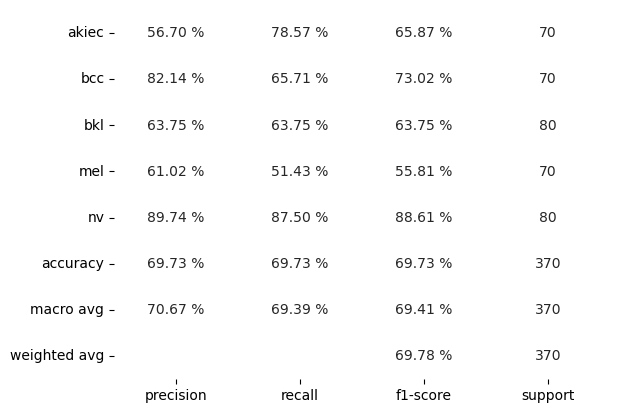

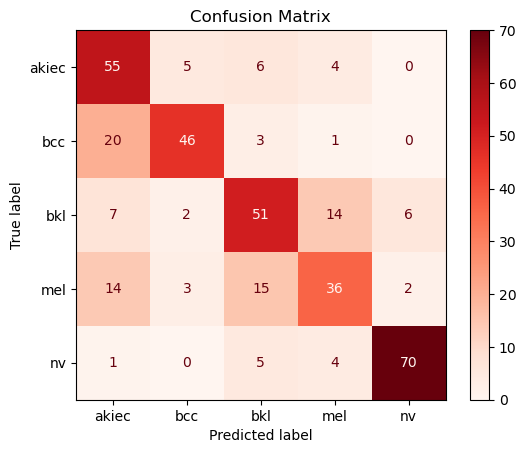


Accuracy of model prediction is: 63.40 %

F1-score of model prediction is: 66.33 %


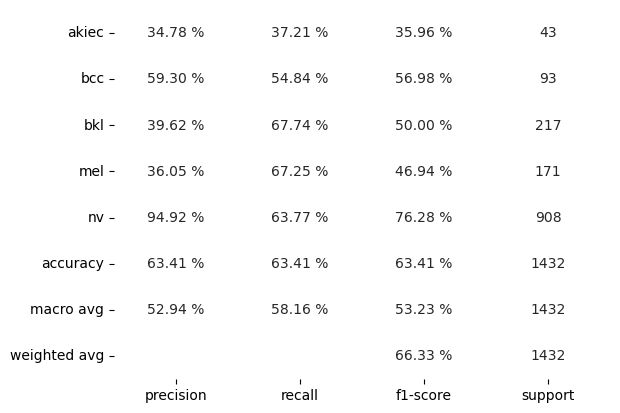

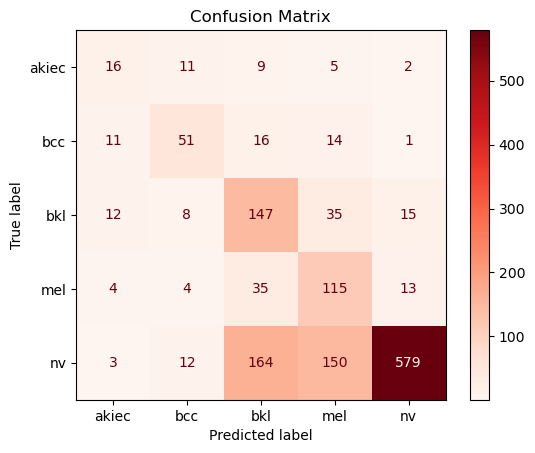

In [12]:
clf = LogisticRegression(random_state=0, max_iter=1000, solver='lbfgs', multi_class='auto')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
EvaluateModel(y_pred, val_set, 'val', name+'-LR', save=True, model_type='LR')

y_pred = clf.predict(X_test)
EvaluateModel(y_pred, test_set, 'test', name+'-LR', save=True, model_type='LR')


Accuracy of model prediction is: 70.00 %

F1-score of model prediction is: 70.24 %


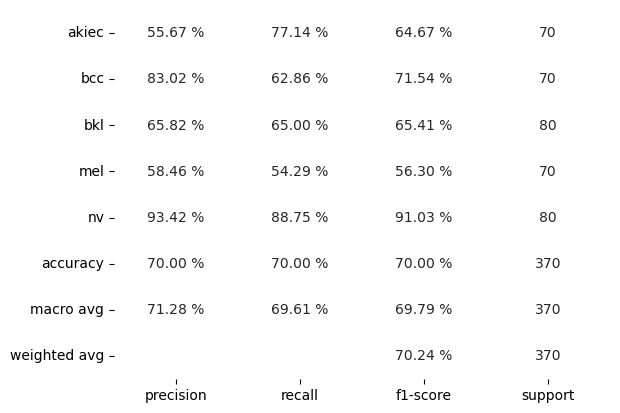

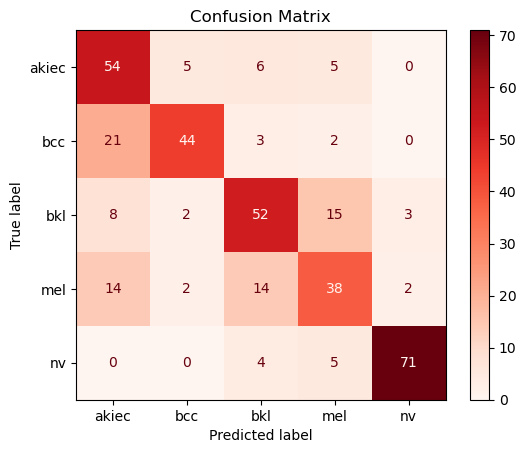


Accuracy of model prediction is: 61.10 %

F1-score of model prediction is: 64.55 %


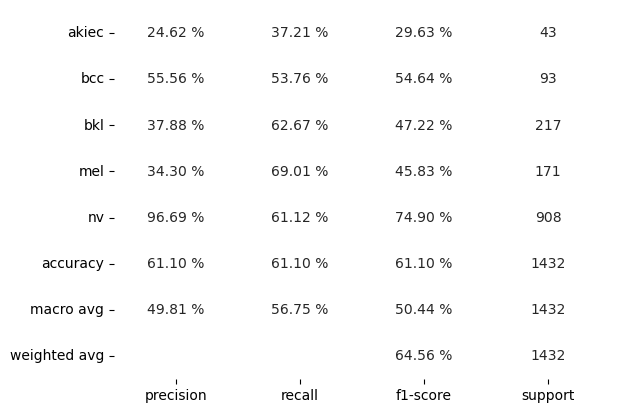

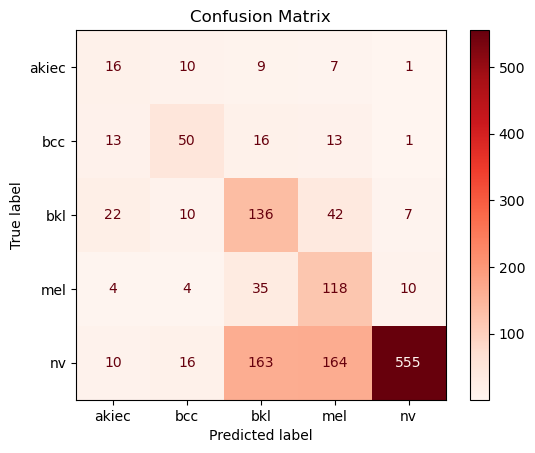

In [13]:
import xgboost as xgb
modelxg = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=1, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=1855, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=0)

modelxg.fit(X_train,y_train)

y_pred = modelxg.predict(X_val)
EvaluateModel(y_pred, val_set, 'val', name+'-XGB', save=True, model_type='XGB')

y_pred = modelxg.predict(X_test)
EvaluateModel(y_pred, test_set, 'test', name+'-XGB', save=True, model_type='XGB')